<a href="https://colab.research.google.com/github/wallykop/iad-deep-learning/blob/master/8_rnn_names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация имени с помощью рекуррентной нейронной сети



In [0]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")

1.15.0


# Загружаем данные

Набор данных содержит ~8 тыс. имен людей из разных культур, все в латинской транскрипции.


In [0]:
from google.colab import files
files.upload()
files.download()

Saving names.txt to names (1).txt


TypeError: ignored

In [0]:
! ls

'names (1).txt'   names.txt   sample_data


In [0]:
start_token = " "  # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [0]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


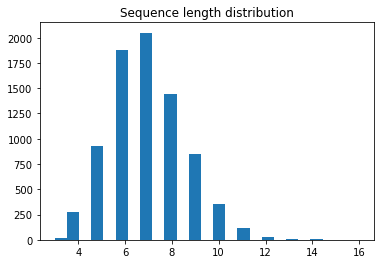

In [0]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Обрабатываем текст

Сначала нужно собрать словарь всех уникальных токенов, т. е. уникальных символов. Затем мы можем кодировать входные данные в виде последовательности кодов символов.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokens = np.unique(list(''.join(names))+ ['#']) ### YOUR CODE HERE: all unique characters go here, padding included!

tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

n_tokens: 56


### Переводим все от символов к идентификаторам

В TensorFlow работа со строками непростая, поэтому упростим ее. Мы будем подавать в нашу рекуррентную нейронную сеть идентификаторы символов из нашего словаря.

Для создания такого словаря определим `token_to_id`

In [0]:
token_to_id = {char:i for i, char in enumerate(tokens)}### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

In [0]:
token_to_id

{' ': 0,
 '#': 1,
 "'": 2,
 '-': 3,
 'A': 4,
 'B': 5,
 'C': 6,
 'D': 7,
 'E': 8,
 'F': 9,
 'G': 10,
 'H': 11,
 'I': 12,
 'J': 13,
 'K': 14,
 'L': 15,
 'M': 16,
 'N': 17,
 'O': 18,
 'P': 19,
 'Q': 20,
 'R': 21,
 'S': 22,
 'T': 23,
 'U': 24,
 'V': 25,
 'W': 26,
 'X': 27,
 'Y': 28,
 'Z': 29,
 'a': 30,
 'b': 31,
 'c': 32,
 'd': 33,
 'e': 34,
 'f': 35,
 'g': 36,
 'h': 37,
 'i': 38,
 'j': 39,
 'k': 40,
 'l': 41,
 'm': 42,
 'n': 43,
 'o': 44,
 'p': 45,
 'q': 46,
 'r': 47,
 's': 48,
 't': 49,
 'u': 50,
 'v': 51,
 'w': 52,
 'x': 53,
 'y': 54,
 'z': 55}

In [0]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [0]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000])) # после пробела начинается имя

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  4 31 30 36 30 34 41  1]
 [ 0 10 41 44 47 54  1  1  1]
 [ 0 19 47 38 48 48 38 34  1]
 [ 0 10 38 44 51 30 43 43 34]]


# Строим рекуррентную нейронную сеть

Мы можем переписать рекуррентную нейронную сеть как последовательное применение полносвязного слоя ко входу $x_t$ и предыдущему состоянию РНС $h_t$.

<img src="https://github.com/grafft/hse-tasks/blob/master/ida-18/sem8/rnn.png?raw=1" width=600>

Поскольку мы обучаем языковую модель, у нас должен быть:
* Трансформационный слой, преобразующий идентификатор символа $x_t$ в вектор.
* Выходной слой, который предсказывает вероятность следующего символа на основе $h_{t+1}$

In [0]:
# remember to reset your session if you change your graph!

from keras import backend as K

def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s


In [0]:
s = reset_tf_session()

In [0]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
get_h_next = Dense(rnn_num_units, activation='tanh')### YOUR CODE HERE

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = Dense(n_tokens, activation = 'softmax')### YOUR CODE HERE 

Генерируем символа имен буква за буквой, начиная с `start_token`:

<img src="https://github.com/grafft/hse-tasks/blob/master/ida-18/sem8/char-nn.png?raw=1" width=600>

In [0]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    x_and_h = concatenate([x_t_emb, h_t])### YOUR CODE HERE
    
    # compute next state given x_and_h
    h_next = get_h_next(x_and_h)### YOUR CODE HERE
    
    # get probabilities for language model P(x_next|h_next)
    output_probas = get_probas(h_next)### YOUR CODE HERE
    
    return output_probas, h_next

# Цикл РНС

Будем применять `rnn_one_step` в цикле по символами имен, чтобы получить прогнозы.

Предположим, что все имена имеют максимальную длину-16, поэтому мы можем просто перебирать их в цикле for.

In [0]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

# РНС: функция потерь и градиенты

Посторим матрицу предсказаний для $P (x_{next}|h)$ и соответствующих правильных ответов.

Мы будем растягивать эту матрицу в вид [None, n_tokens].

РНС может быть обучена путем минимизации кроссэнтропии между предсказанными вероятностями и этими ответами.

In [0]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [0]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Remember to apply tf.reduce_mean to get a scalar loss!
loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(answers_matrix, predictions_matrix))### YOUR CODE HERE

optimize = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# РНС: обучение

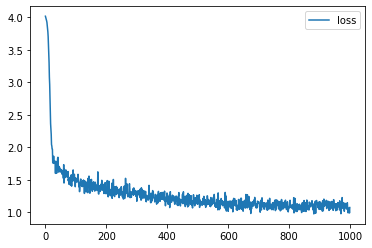

In [0]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# РНС: генерация

После того, как мы немного обучили нашу сеть, давайте перейдем к фактической генерации имен. Все, что нам нужно-это функция `rnn_one_step'.

In [0]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

# For sampling we need to define `rnn_one_step` tensors only once in our graph.
# We reuse all parameters thanks to functional API usage.
# Then we can feed appropriate tensor values using feed_dict in a loop.
# Note how different it is from training stage, where we had to unroll the whole sequence for backprop.
next_probs, next_h = rnn_one_step(x_t, h_t)

In [0]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [0]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Ro ey
 Kerrete
 Nodden
 Maody
 Rotce
 Hiacne
 Mancil
 Ararmlan
 Budra
 Colien


In [0]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Valentin'))

 Valentin
 Valentin
 Valentine
 Valentins
 Valentina
 Valentin
 Valentinr
 Valentina
 Valentin
 Valentin


# Динамические РНС

Помимо Keras, есть также TensorFlow API для рекуррентных нейронных сетей. В его основе лежит функция символьного цикла (ака [tf.scan](https://www.tensorflow.org/api_docs/python/tf/scan)).

РНС цикл, который мы реализовали для обучения, может быть заменен на однуTensorFlow инструкцию: [tf.nn.dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn). Этот интерфейс учитывает динамическую длину последовательности и идет с некоторыми предобученными архитектурами.

[tf.nn.rnn_cell.BasicRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell).

In [0]:
class CustomRNN(tf.nn.rnn_cell.BasicRNNCell):
    def call(self, input, state):
        # from docs:
        # Returns:
        # Output: A 2-D tensor with shape [batch_size, self.output_size].
        # New state: Either a single 2-D tensor, or a tuple of tensors matching the arity and shapes of state.
        return rnn_one_step(input[:, 0], state)
    
    @property
    def output_size(self):
        return n_tokens
    
cell = CustomRNN(rnn_num_units)

input_sequence = tf.placeholder(tf.float32, (None, None))
    
predicted_probas, last_state = tf.nn.dynamic_rnn(cell, input_sequence[:, :, None], dtype=tf.float32)

print('LSTM outputs for each step [batch,time,n_tokens]:')
print(predicted_probas.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


LSTM outputs for each step [batch,time,n_tokens]:
(10, 50, 56)


Обратите внимание, что мы никогда не использовали MAX_LENGTH в коде выше: TF будет перебирать столько временных шагов, сколько вы ему дали.

Можно также использовать любую предварительно реализованную ячейку РНС:

In [0]:
for obj in dir(tf.nn.rnn_cell) + dir(tf.contrib.rnn):
    if obj.endswith('Cell'):
        print(obj)

BasicLSTMCell
BasicRNNCell
GRUCell
LSTMCell
MultiRNNCell
RNNCell
BasicLSTMCell
BasicRNNCell
BidirectionalGridLSTMCell
Conv1DLSTMCell
Conv2DLSTMCell
Conv3DLSTMCell
ConvLSTMCell
CoupledInputForgetGateLSTMCell
FusedRNNCell
GLSTMCell
GRUBlockCell
GRUCell
GridLSTMCell
IndRNNCell
IndyGRUCell
IndyLSTMCell
IntersectionRNNCell
LSTMBlockCell
LSTMBlockFusedCell
LSTMCell
LayerNormBasicLSTMCell
LayerRNNCell
MultiRNNCell
NASCell
PhasedLSTMCell
RNNCell
SRUCell
TimeFreqLSTMCell
UGRNNCell


In [0]:
input_sequence = tf.placeholder(tf.int32, (None, None))

inputs_embedded = embed_x(input_sequence)

# standard cell returns hidden state as output!
cell = tf.nn.rnn_cell.LSTMCell(rnn_num_units)

state_sequence, last_state = tf.nn.dynamic_rnn(cell, inputs_embedded, dtype=tf.float32)

s.run(tf.global_variables_initializer())

print('LSTM hidden state for each step [batch,time,rnn_num_units]:')
print(state_sequence.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


KeyboardInterrupt: ignored